# Illya-BOICHUK-Camp-2025

## Answer

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/electricity_consumption_and_production.csv")
df["DateTime"] = pd.to_datetime(df["DateTime"])
df.set_index("DateTime", inplace=True)
daily_df = df["Consumption"].resample("D").mean()

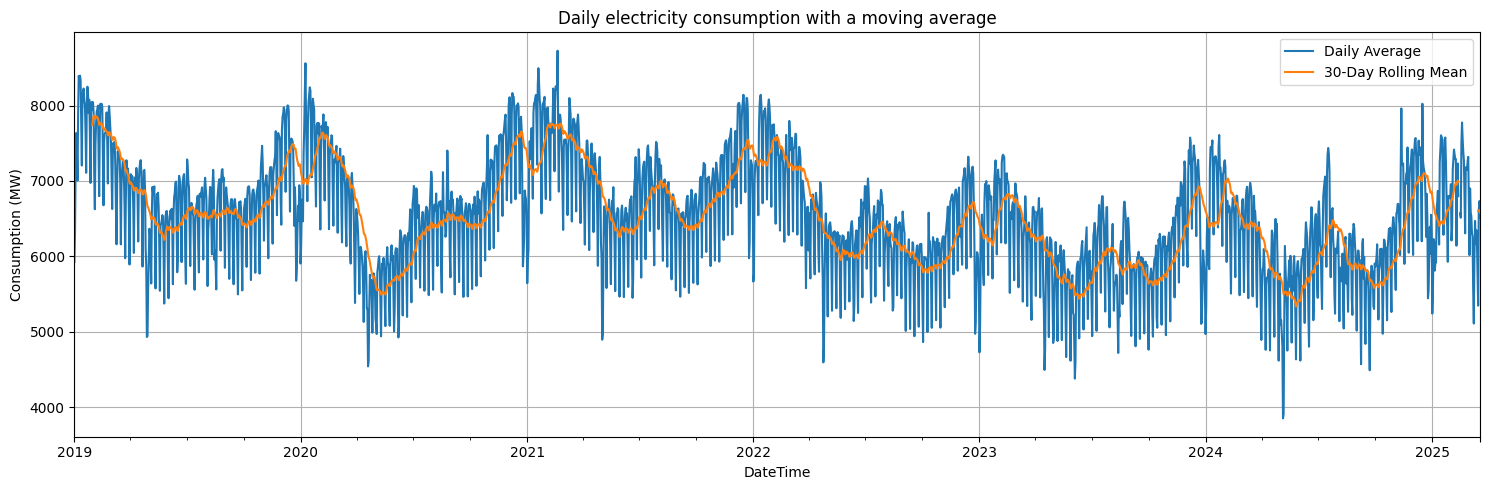

In [4]:
plt.figure(figsize=(15, 5))
daily_df.plot(label='Daily Average')
daily_df.rolling(30).mean().plot(label='30-Day Rolling Mean')
plt.title("Daily electricity consumption with a moving average")
plt.ylabel("Consumption (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

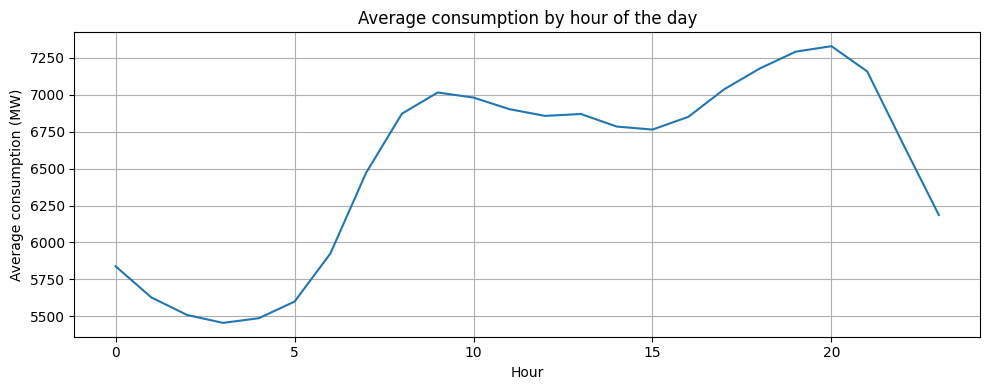

In [5]:
df["Hour"] = df.index.hour
hourly_avg = df.groupby("Hour")["Consumption"].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title("Average consumption by hour of the day")
plt.xlabel("Hour")
plt.ylabel("Average consumption (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

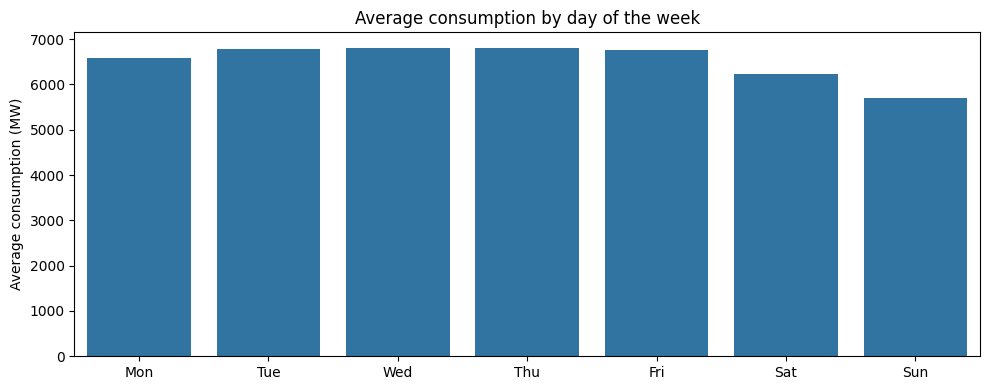

In [6]:
df["Weekday"] = df.index.weekday
weekday_avg = df.groupby("Weekday")["Consumption"].mean()

plt.figure(figsize=(10, 4))
sns.barplot(x=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], y=weekday_avg.values)
plt.title("Average consumption by day of the week")
plt.ylabel("Average consumption (MW)")
plt.tight_layout()
plt.show()

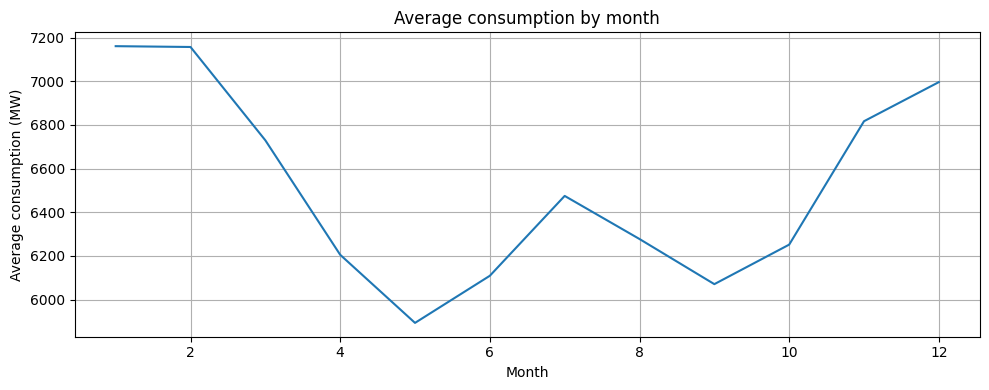

In [7]:
df["Month"] = df.index.month
monthly_avg = df.groupby("Month")["Consumption"].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title("Average consumption by month")
plt.xlabel("Month")
plt.ylabel("Average consumption (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
target_series = df["Consumption"]
train_size = 1000 

train_series = target_series[:train_size]
test_series = target_series[train_size:]

### SARIMAX

d:\Anaconda\envs\les_23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\envs\les_23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\envs\les_23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Anaconda\envs\les_23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_

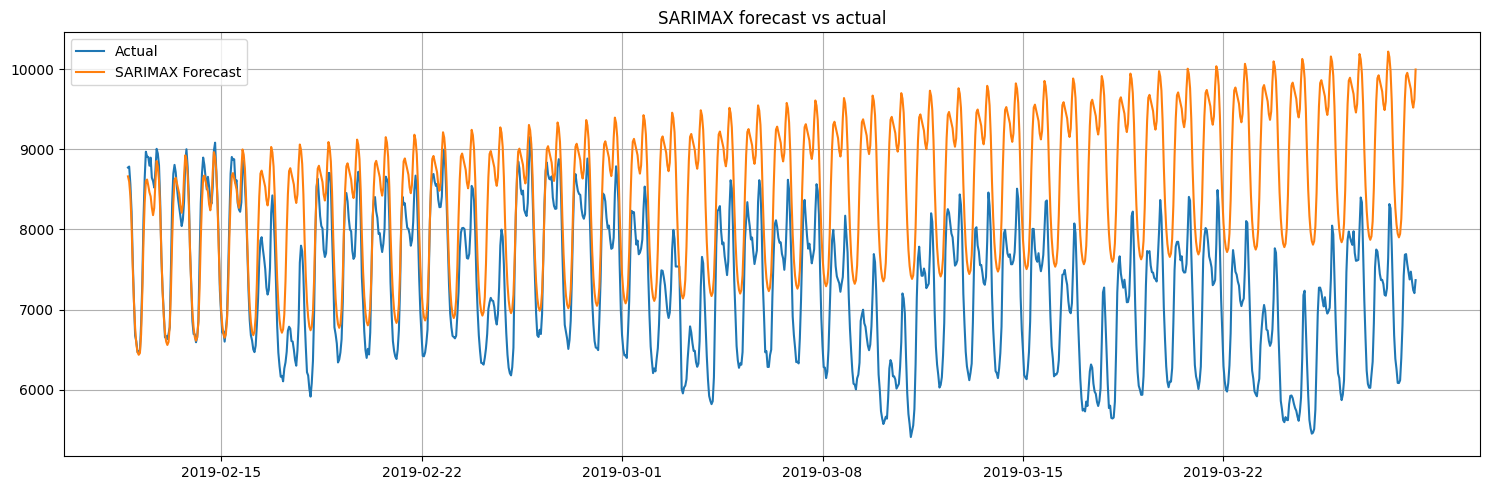

SARIMAX RMSE: 1535.1404;
SARIMAX MAE: 1285.6343;
SARIMAX R²: -2.0780;
SARIMAX Training Time: 15.29 s


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time 

def create_lagged_features(series, lags=24):
    df_lagged = pd.concat([series.shift(i) for i in range(1, lags + 1)], axis=1)
    df_lagged.columns = [f"lag_{i}" for i in range(1, lags + 1)]
    df_lagged["target"] = series.values
    df_lagged.dropna(inplace=True)  
    return df_lagged

lagged_data_sarimax = create_lagged_features(train_series, lags=24)
X_sarimax_train = lagged_data_sarimax.drop("target", axis=1)
y_sarimax_train = lagged_data_sarimax["target"]
start_time = time.time()
model_sarimax = SARIMAX(y_sarimax_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model_sarimax_fit = model_sarimax.fit(disp=False)
end_time = time.time()
sarimax_train_time = end_time - start_time
forecast_sarimax = model_sarimax_fit.forecast(steps=1080)

plt.figure(figsize=(15, 5))
plt.plot(test_series.index[:1080], test_series[:1080], label="Actual")
plt.plot(test_series.index[:1080], forecast_sarimax, label="SARIMAX Forecast")
plt.legend()
plt.title("SARIMAX forecast vs actual")
plt.grid()
plt.tight_layout()
plt.show()

rmse_sarimax = np.sqrt(mean_squared_error(test_series[:len(forecast_sarimax)], forecast_sarimax))
mae_sarimax = mean_absolute_error(test_series[:len(forecast_sarimax)], forecast_sarimax)
r2_sarimax = r2_score(test_series[:len(forecast_sarimax)], forecast_sarimax)
print(f"SARIMAX RMSE: {rmse_sarimax:.4f};\nSARIMAX MAE: {mae_sarimax:.4f};\nSARIMAX R²: {r2_sarimax:.4f};\nSARIMAX Training Time: {sarimax_train_time:.2f} s")


### Prophet

d:\Anaconda\envs\les_23\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
14:00:04 - cmdstanpy - INFO - Chain [1] start processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
d:\Anaconda\envs\les_23\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


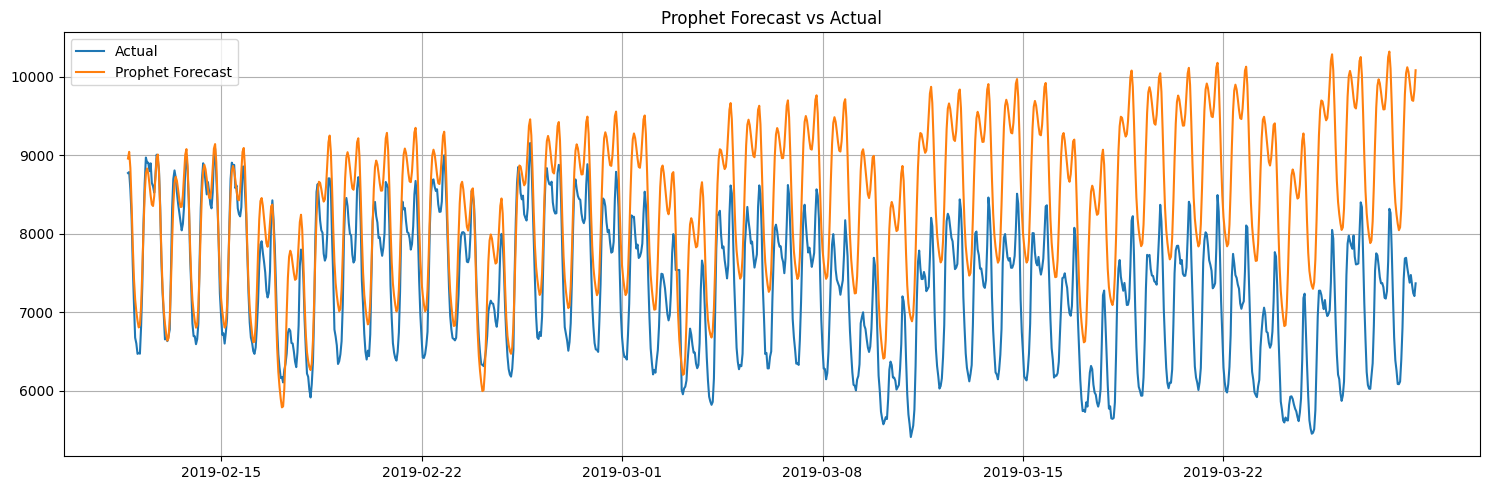

Prophet RMSE: 1377.2086,
Prophet MAE: 1170.2683,
Prophet R²: -1.4773,
Prophet Training Time: 0.81 s


In [10]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

df_prophet = train_series.reset_index()
df_prophet.columns = ["ds", "y"]
start_time = time.time()
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(df_prophet)
end_time = time.time()
prophet_train_time = end_time - start_time
future = model.make_future_dataframe(periods=1080, freq="H")
forecast_prophet = model.predict(future)
forecast_values = forecast_prophet.set_index("ds").loc[test_series.index[:1080], "yhat"]


plt.figure(figsize=(15,5))
plt.plot(test_series.index[:1080], test_series[:1080], label="Actual")
plt.plot(test_series.index[:1080], forecast_values, label="Prophet Forecast")
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

rmse_prophet = np.sqrt(mean_squared_error(test_series[:1080], forecast_values))
mae_prophet = mean_absolute_error(test_series[:1080], forecast_values)
r2_prophet = r2_score(test_series[:1080], forecast_values)
print(f"Prophet RMSE: {rmse_prophet:.4f},\nProphet MAE: {mae_prophet:.4f},\nProphet R²: {r2_prophet:.4f},\nProphet Training Time: {prophet_train_time:.2f} s")


### Random forest regressor

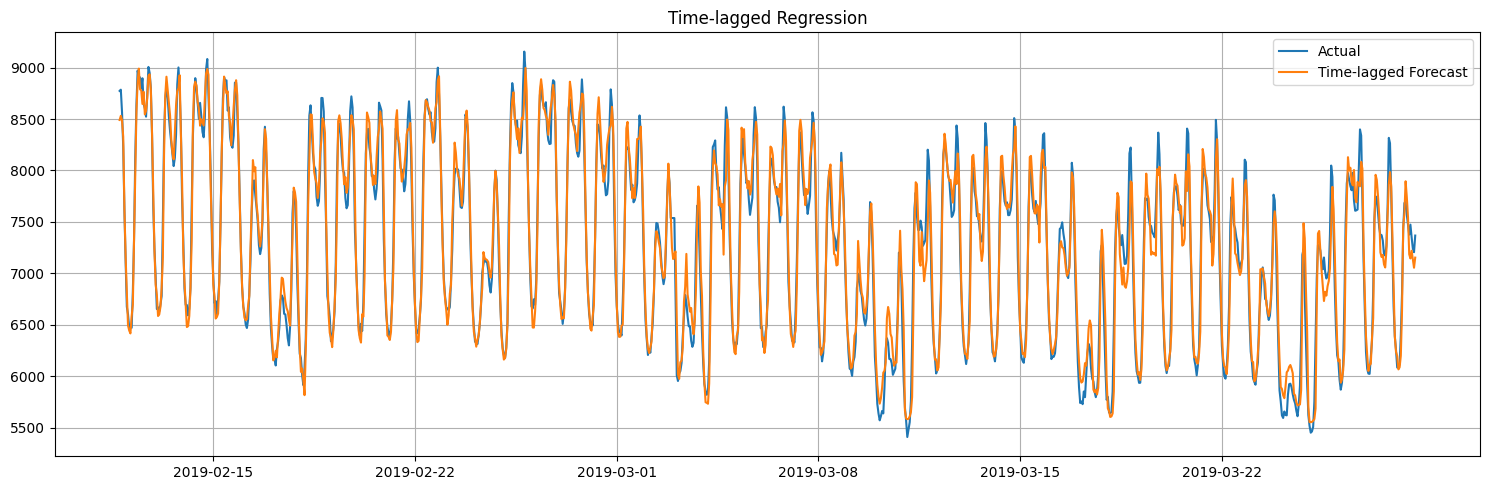

Time-lagged RMSE: 184.9796,
Time-lagged MAE: 140.6338,
Time-lagged R²: 0.9553,
Training Time: 3.29 s


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time 

def create_lagged_features(series, lags=24):
    df_lagged = pd.concat([series.shift(i) for i in range(1, lags + 1)], axis=1)
    df_lagged.columns = [f"lag_{i}" for i in range(1, lags + 1)]
    df_lagged["target"] = series.values
    df_lagged.dropna(inplace=True)
    return df_lagged

lagged_data = create_lagged_features(target_series, lags=24)
X = lagged_data.drop("target", axis=1)
y = lagged_data["target"]
X_train, X_test = X.iloc[:train_size-24], X.iloc[train_size-24:]
y_train, y_test = y.iloc[:train_size-24], y.iloc[train_size-24:]
start_time = time.time()
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
end_time = time.time()
rf_train_time = end_time - start_time
pred_rf = model_rf.predict(X_test[:1080])

plt.figure(figsize=(15, 5))
plt.plot(test_series.index[:1080], y_test[:1080], label="Actual")
plt.plot(test_series.index[:1080], pred_rf, label="Time-lagged Forecast")
plt.legend()
plt.title("Time-lagged Regression")
plt.grid()
plt.tight_layout()
plt.show()

rmse_rf = np.sqrt(mean_squared_error(y_test[:1080], pred_rf))
mae_rf = mean_absolute_error(y_test[:1080], pred_rf)
r2_rf = r2_score(y_test[:1080], pred_rf)
print(f"Time-lagged RMSE: {rmse_rf:.4f},\nTime-lagged MAE: {mae_rf:.4f},\nTime-lagged R²: {r2_rf:.4f},\nTraining Time: {rf_train_time:.2f} s")

### LSTM

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3471
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0315
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0278
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0242
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0233
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0221
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0207
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0197
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0187
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


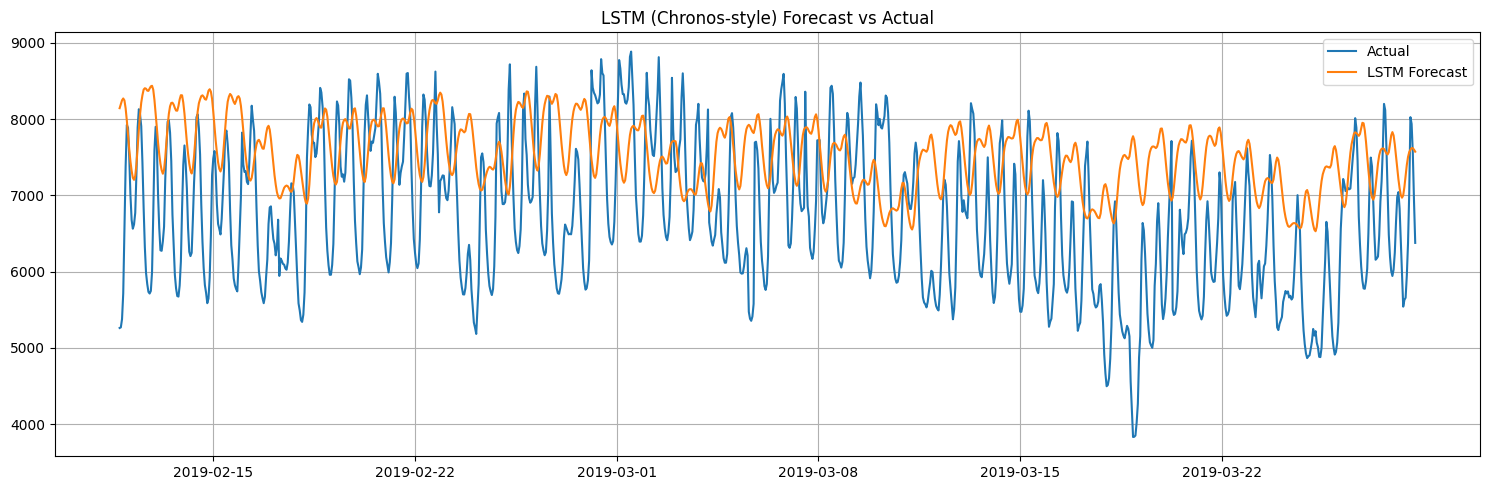

LSTM RMSE: 1292.7867,
TLSTM MAE: 1079.3258,
TLSTM R²: -0.8543,
Training Time: 8.59 s


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import time

scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(target_series.values.reshape(-1, 1))

def create_lstm_data(series, window=24):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_lstm_data(scaled_series, window=24)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1)) 
X_train, X_test = X_lstm[:train_size-24], X_lstm[train_size-24:]
y_train, y_test = y_lstm[:train_size-24], y_lstm[train_size-24:]

model_lstm = Sequential([
    Input(shape=(24, 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
start_time = time.time()
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
end_time = time.time()
lstm_train_time = end_time - start_time
pred_lstm = model_lstm.predict(X_test[:1080])
pred_lstm = scaler.inverse_transform(pred_lstm) 

plt.figure(figsize=(15, 5))
plt.plot(test_series.index[:1080], target_series.iloc[-1080:], label="Actual")
plt.plot(test_series.index[:1080], pred_lstm, label="LSTM Forecast")
plt.legend()
plt.title("LSTM (Chronos-style) Forecast vs Actual")
plt.grid()
plt.tight_layout()
plt.show()

true_vals = target_series.iloc[-1080:].values.reshape(-1, 1)

rmse_lstm = np.sqrt(mean_squared_error(true_vals, pred_lstm))
mae_lstm = mean_absolute_error(true_vals, pred_lstm)
r2_lstm = r2_score(true_vals, pred_lstm)
print(f"LSTM RMSE: {rmse_lstm:.4f},\nTLSTM MAE: {mae_lstm:.4f},\nTLSTM R²: {r2_lstm:.4f},\nTraining Time: {lstm_train_time:.2f} s")


### Chronos‑Bolt

INFO:pytorch_lightning.utilities.seed:Global seed set to 1535873911
INFO:pytorch_lightning.utilities.seed:Global seed set to 1535873911
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | NormalizeTSModel | 4.3 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 63/63 [00:02<00:00, 24.42it/s, loss=8.31e+04, v_num=0, val/loss=1.02e+5]


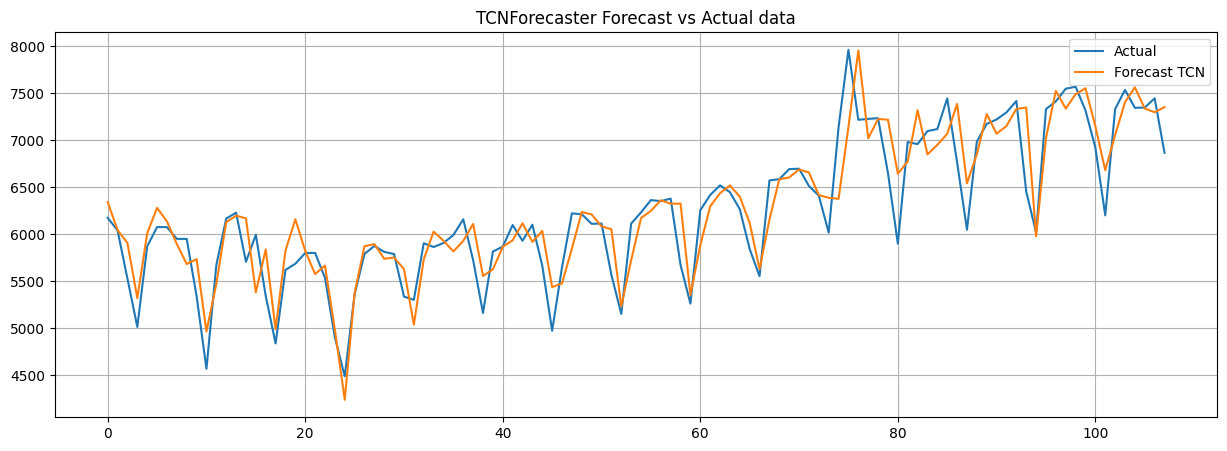

Chronos‑Bolt RMSE: 360.0506,
Chronos‑Bolt MAE: 264.6581,
Chronos‑Bolt R²: 0.7522,
Training Time: 30.82 s


In [ ]:
from bigdl.chronos.forecaster import TCNForecaster
from bigdl.chronos.data import TSDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

df = pd.read_csv("data/electricity_consumption_and_production.csv")
df["DateTime"] = pd.to_datetime(df["DateTime"])
df.set_index("DateTime", inplace=True)
daily_df = df["Consumption"].resample("D").mean()

target_df = pd.DataFrame({
    "timestamp": daily_df.index,
    "value":     daily_df.values
})

ts_train, ts_val, ts_test = TSDataset.from_pandas(
    df=target_df,
    dt_col="timestamp",
    target_col="value",
    with_split=True,
    val_ratio=0.1,
    test_ratio=0.1
)

train_x, train_y = ts_train.roll(
    lookback=24, 
    horizon=1,  
    time_enc=False
).to_numpy()

val_x, val_y = ts_val.roll(
    lookback=24,
    horizon=1,
    time_enc=False
).to_numpy()

test_x, test_y = ts_test.roll(
    lookback=24,
    horizon=1,
    time_enc=False
).to_numpy()

tcn = TCNForecaster.from_tsdataset(
    ts_train,
    past_seq_len=24,
    future_seq_len=1
)

start = time.time()
tcn.fit(
    (train_x, train_y),
    validation_data=(val_x, val_y),
    epochs=10,
    batch_size=32
)
train_time = time.time() - start
yhat = tcn.predict(test_x)
y_true_flat = test_y.squeeze() 
y_pred_flat = yhat.squeeze()    

plt.figure(figsize=(15, 5))
plt.plot(y_true_flat[:108], label="Actual")
plt.plot(y_pred_flat[:108], label="Forecast TCN")
plt.title("TCNForecaster Forecast vs Actual data")
plt.legend()
plt.grid()
plt.show()

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mae_chronos = mean_absolute_error(y_true_flat, y_pred_flat)
r2_chronos = r2_score(y_true_flat, y_pred_flat)
print(f"Chronos‑Bolt RMSE: {rmse:.4f},\nChronos‑Bolt MAE: {mae_chronos:.4f},\nChronos‑Bolt R²: {r2_chronos:.4f},\nTraining Time: {train_time:.2f} s")


### Model comparison

In [14]:
import pandas as pd

metrics_df = pd.DataFrame({
    "Model": ["SARIMAX", "Prophet", "Random Forest", "LSTM", "Chronos-Bolt"],
    "RMSE": [rmse_sarimax, rmse_prophet, rmse_rf, rmse_lstm, 360.0506],
    "MAE": [mae_sarimax, mae_prophet, mae_rf, mae_lstm, 264.6581],
    "R2": [r2_sarimax, r2_prophet, r2_rf, r2_lstm, 0.7522],
    "Train Time (s)": [sarimax_train_time, prophet_train_time, rf_train_time, lstm_train_time, 30.82]
})

print(metrics_df)

           Model         RMSE          MAE        R2  Train Time (s)
0        SARIMAX  1535.140409  1285.634294 -2.078014       15.294302
1        Prophet  1377.208556  1170.268323 -1.477273        0.805720
2  Random Forest   184.979598   140.633778  0.955309        3.289345
3           LSTM  1292.786719  1079.325806 -0.854254        8.586251
4   Chronos-Bolt   360.050600   264.658100  0.752200       30.820000


Random Forest showed the best accuracy with the lowest RMSE and MAE values, as well as a high coefficient of determination R² of about 0.96. At the same time, the training time was relatively short - about three seconds, which makes this model efficient and fast for forecasting. Chronos-Bolt ranked second in terms of forecast quality with an RMSE significantly better than classical time-based models and an R² of 0.75, but its training time was the longest, about 31 seconds, which is explained by the complexity of the deep neural network. LSTM performed better than classical temporal models but worse than Random Forest and Chronos-Bolt, with a moderate training time of about 9 seconds. Prophet is fast, has a training time of less than a second, but shows a negative coefficient of determination, which indicates insufficient forecast quality. SARIMAX has the worst accuracy and a longer training time of about 15 seconds, which indicates that the model does not fit the data well enough.

Overall, Random Forest proved to be the most effective model for this dataset, as it combines high accuracy with fast training. Chronos-Bolt is more suitable if it is more important to get a better forecast despite the higher computational cost. Other models can be useful for basic estimates or when resources are limited.